"""I/we certify that the code and data in this assignment were generated independently, using only the
tools and resources defined in the course and that I/we did not receive any external help, coaching or
contributions during the production of this work."""

In [1]:
import numpy as np
import time

In [2]:
import gym

In [3]:
import torch
from torch import nn

In [4]:
env = gym.make('CartPole-v1')

In [ ]:
help(env.unwrapped)

In [ ]:
for _ in range(5):
    obs = env.reset()
    for _ in range(80):
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        env.render()
        time.sleep(0.05)

env.close()

In [ ]:
env.observation_space

In [ ]:
env.observation_space

In [ ]:
episodes = 500

In [ ]:
reward_arr = []
for _ in range(episodes):
    obs = env.reset()
    rew=0
    while True:
        action = np.random.choice(env.action_space.n)
        obs, reward, done, info = env.step(action)
        rew+= reward
        if done:
            break
    reward_arr.append(rew)
print(f"avg reward: {sum(reward_arr)/episodes}")

In [ ]:

from torch import randint

In [ ]:
rew_arr = []
episode_count = 100
env = gym.make('CartPole-v0')
for i in range(episode_count):
    obs, done, rew = env.reset(), False, 0
    while (done != True) :
        A =  randint(0,env.action_space.n,(1,))
        obs, reward, done, info = env.step(A.item())
        rew += reward
    rew_arr.append(rew)
    
print("average reward per episode :",sum(rew_arr)/ len(rew_arr))

In [ ]:
randint(0,env.action_space.n,(1,))

In [5]:
import numpy as np
import torch
from torch import nn
import gym
import random
from collections import deque
import matplotlib.pyplot as plt
import itertools

In [6]:
env = gym.make('CartPole-v1')
env.seed(0)

[0]

In [7]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()
        in_features = 4
        self.linear_stack = nn.Sequential(
                            nn.Linear(in_features, 64),
                            nn.ReLU(),
                            nn.Linear(64, 64),
                            nn.ReLU(),
                            nn.Linear(64, env.action_space.n),
                            nn.Identity())
        self.env = env
    
    def forward(self, x):
        return self.linear_stack(x)
    
    
    def get_action(self, obs, val = 100, eps=0):
        if val < eps:
            return self.env.action_space.sample()
        else:
#             return self(torch.as_tensor(obs).to(device)).argmax().item()
            return self(obs.to(device)).argmax(dim=-1).item()
#             obs_t = torch.as_tensor(obs, dtype=torch.float32)
#             q_value = self(obs_t.unsqueeze(0))
#             print(q_value)
#             max_q = torch.argmax(q_value, dim=1)[0]
#             action = max_q.detach().item()
#             return action


In [10]:
def to_tensor(np_array: np.array, size = None) -> torch.tensor:
    torch_tensor = torch.from_numpy(np_array).float()
    if size is not None:
        torch_tensor = torch_tensor.view(size)
    return torch_tensor

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 50000
MIN_REPLY_SIZE=1000
TARGET_UPDATE_FREQ = 1000

gama = 0.99
eps = 1.0
num_episodes = 5000
max_steps = 500
eps_decay = (0.01/eps) ** (1/num_episodes)
interval = 1000

In [12]:
pred_net = NeuralNetwork(env).to(device)
target_net = NeuralNetwork(env).to(device)
replay_buffer = deque(maxlen=BUFFER_SIZE)
target_net.load_state_dict(pred_net.state_dict())

<All keys matched successfully>

In [13]:
optimizer = torch.optim.Adam(pred_net.parameters(), 5e-4)

In [14]:
#initialize reply buffer
state = env.reset()
for _ in range(MIN_REPLY_SIZE):
    action = env.action_space.sample()
    state = to_tensor(state, (1, 4))
    next_state, reward, done, info = env.step(action)
#     new_obs, reward, done, info = env.step(2)
    transition = (state, torch.tensor(action).view(1,1),torch.tensor(reward).view(1,1),torch.tensor(done).view(1,1),torch.tensor(next_state).view(1,4))
    replay_buffer.append(transition)
    state = next_state
    
    if done:
        state = env.reset()

In [15]:
#MAIN ACTION
total_reward = []
print_every = 100
tau = 1e-3
reward_window = deque(maxlen=100)
epsilon=[]
t1 = time.time()
count = 0
# for epi in itertools.count():
for epi in range(num_episodes):
    count+=1
    state = env.reset()
    epsilon.append(eps)
    epi_reward = 0
    for step in range(max_steps):
        count += 1
        val=np.random.random()
        state = to_tensor(state, (1, 4))
        action = pred_net.get_action(state, val, eps)
        next_state, reward, done, info = env.step(action)
        
        transition = (state, torch.tensor(action).view(1,1),torch.tensor(reward).view(1,1),torch.tensor(done).view(1,1),torch.tensor(next_state).view(1,4))
        replay_buffer.append(transition)
        state = next_state
        epi_reward += reward
        
        states = []
        actions = []
        rewards = []
        dones = []
        next_states = []
        
        if step % interval == 0:
#             if len(replay_buffer) >= BATCH_SIZE:
            sample = [replay_buffer[i] for i in random.sample(range(len(replay_buffer)), BATCH_SIZE)]
            for i in sample:
                states.append(i[0])
                actions.append(i[1])
                rewards.append(i[2])
                dones.append(i[3])
                next_states.append(i[4])
            states = torch.cat(states, dim=0).float().to(device)
            actions = torch.cat(actions, dim=0).to(device)
            rewards = torch.cat(rewards, dim=0).float().to(device)
            dones = torch.cat(dones, dim=0).float().to(device)
            next_states = torch.cat(next_states, dim=0).float().to(device)
            with torch.no_grad():
                max_q, _ = target_net(next_states).max(dim=-1, keepdims=True)
                q_target = rewards + gama * max_q * (1-dones)
            q_val = pred_net(states).gather(1, actions)
#             loss = nn.MSELoss(q_val, q_target)
            loss = nn.functional.smooth_l1_loss(q_val, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for target_params, q_params in zip(target_net.parameters(),pred_net.parameters()):
                target_params.data.copy_(tau * q_params.data + (1.0 - tau) * target_params.data)
        if done:
            break
    total_reward.append(epi_reward)
    reward_window.append(epi_reward)
    
    if epi % print_every == (print_every - 1):
        print(f"Episode: {epi + 1:4.0f}\t| " 
              + f"Score: {epi_reward:3.2f}\t| "
              + f"Avg Score: {np.mean(reward_window):3.2f}\t| "
              +f"Eps: {eps:.3f}\n")
    eps *= eps_decay
    if np.mean(reward_window) >= 450.0:
        print(f"CartPole-v1 solved in the {epi + 1}th episode." +f"\tAvg Score: {np.mean(reward_window):3.2f}")
        # Save the model.
        torch.save(pred_net.state_dict(), "dqn_for_cp-v1.pth")
        break

t2 = time.time()
print("The time of execution of the DQN algorithm is: ", t2 - t1)

Episode:  100	| Score: 23.00	| Avg Score: 21.69	| Eps: 0.913

Episode:  200	| Score: 13.00	| Avg Score: 19.64	| Eps: 0.833

Episode:  300	| Score: 26.00	| Avg Score: 18.56	| Eps: 0.759

Episode:  400	| Score: 27.00	| Avg Score: 17.72	| Eps: 0.692

Episode:  500	| Score: 18.00	| Avg Score: 17.29	| Eps: 0.632

Episode:  600	| Score: 16.00	| Avg Score: 15.85	| Eps: 0.576

Episode:  700	| Score: 10.00	| Avg Score: 14.28	| Eps: 0.525

Episode:  800	| Score: 14.00	| Avg Score: 13.76	| Eps: 0.479

Episode:  900	| Score: 12.00	| Avg Score: 13.93	| Eps: 0.437

Episode: 1000	| Score: 16.00	| Avg Score: 12.49	| Eps: 0.398

Episode: 1100	| Score: 19.00	| Avg Score: 12.50	| Eps: 0.363

Episode: 1200	| Score: 10.00	| Avg Score: 12.88	| Eps: 0.331

Episode: 1300	| Score: 10.00	| Avg Score: 12.11	| Eps: 0.302

Episode: 1400	| Score: 13.00	| Avg Score: 14.17	| Eps: 0.276

Episode: 1500	| Score: 15.00	| Avg Score: 12.74	| Eps: 0.251

Episode: 1600	| Score: 14.00	| Avg Score: 13.66	| Eps: 0.229

Episode:

In [81]:
torch.save(pred_net.state_dict(), "dqn_for_cp-v1.pth")

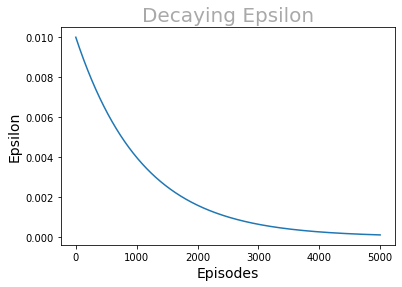

In [62]:
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(epsilon)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Epsilon", color = "black", fontsize = 14)
plt.title('Decaying Epsilon', color = "darkgrey", fontsize = 20)
plt.show()

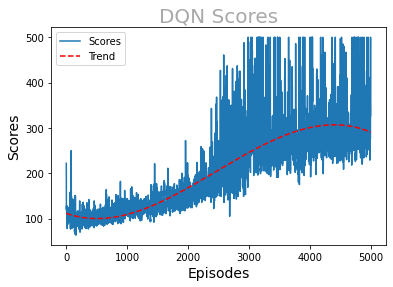

In [68]:
# the plot for rewards
x = np.arange(num_episodes) + 1
y = np.array(total_reward)
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(total_reward)
ax.plot(x, p(x), 'r--')
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Scores", color = "black", fontsize = 14)
plt.title('DQN Scores', color = "darkgrey", fontsize = 20)
plt.legend(['Scores', 'Trend'])
plt.show()

For video encoding and playing, we refer to the following online manual.

IPython Documentation: https://ipython.readthedocs.io/en/stable/index.html

In [95]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [118]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import glob
import base64
from base64 import b64encode
import io
from IPython.display import display
from IPython.display import HTML
import math
from IPython import display as ipythondisplay

In [102]:
import pyglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

In [103]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [104]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [106]:
rec_env = wrap_env(gym.make('CartPole-v1'))
rec_env.seed(0)

[0]

In [132]:
env = gym.make('CartPole-v1')

In [133]:
def record_mp4(successful_case, env, set_seed, video_name):
    env.seed(set_seed) # the same seed as the one for which out model has been trained
    path = f"video/{video_name}.mp4"
    video = VideoRecorder(env, path)
    state = env.reset()
    epi_reward = 0
    while True:
        frame = env.render(mode = 'rgb_array')
        video.capture_frame()
        state = to_tensor(state, size = (1, 4))
        action = successful_case.get_action(state)
        state, reward, done, _ = env.step(action)
        epi_reward += reward
        if done:
            video.close()
            break
    env.close()
    return epi_reward

def render_mp4(video_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4_path = f"video/{video_name}.mp4"
        mp4 = io.open(mp4_path, 'r+b').read()
        base64_encoded_mp4 = b64encode(mp4).decode('ascii')
        display(HTML(data = f'<video alt="test" autoplay loop' \
                            f'controls style="height: 400px;">' \
                            f'<source src="data:video/mp4;base64,' \
                            f'{base64_encoded_mp4}" ' \
                            f'type="video/mp4"></video>'))
    else:
        print("No video available")

In [134]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [135]:
# Q-network for overwriting the successful model previously saved
q_network_success = NeuralNetwork(env).to(device)
q_network_success.load_state_dict(torch.load('dqn_for_cp-v1.pth'))

<All keys matched successfully>

In [136]:
eval_epi_reward = []
for i in range(5):
  eval_epi_reward.append(record_mp4(q_network_success, env, 0, f'cp_v1_dqn-{i+1}'))

In [139]:
eval_epi_reward

[357.0, 357.0, 357.0, 357.0, 357.0]

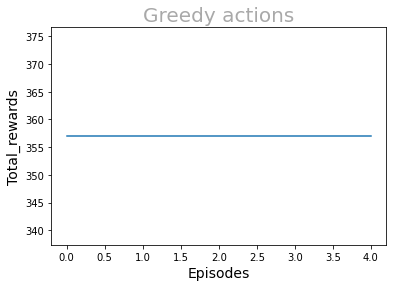

In [141]:
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(eval_epi_reward)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total_rewards", color = "black", fontsize = 14)
plt.title('Greedy actions', color = "darkgrey", fontsize = 20)
plt.show()

In [125]:
render_mp4('cp_v1_dqn')

In [122]:
gym.__version__

'0.17.3'

In [123]:
# eps = 0.0
state = rec_env.reset()
rec_env.render()
while True:
  state = to_tensor(state, size=(1, 4))
  action = q_network_success.get_action(state)
  state, reward, done, _ = rec_env.step(action)
  rec_env.render()
  if done:
    break
env.close()
show_video()

# Double DQN

In [ ]:
!nvidia-smi

In [146]:
class DoubleNeuralNetwork(nn.Module):
    def __init__(self, env):
        super(DoubleNeuralNetwork, self).__init__()
        in_features = 4
        self.linear_stack = nn.Sequential(
                            nn.Linear(in_features, 64),
                            nn.ReLU(),
                            nn.Linear(64, 64),
                            nn.ReLU(),
                            nn.Linear(64, env.action_space.n),
                            nn.Identity())
        self.env = env
    
    def forward(self, x):
        return self.linear_stack(x)
    
    
    def get_action(self, obs, val=100, eps=0):
        if val < eps:
            return self.env.action_space.sample()
        else:
#             return self(torch.as_tensor(obs).to(device)).argmax().item()
            return self(obs.to(device)).argmax(dim=-1).item()
#             obs_t = torch.as_tensor(obs, dtype=torch.float32)
#             q_value = self(obs_t.unsqueeze(0))
#             print(q_value)
#             max_q = torch.argmax(q_value, dim=1)[0]
#             action = max_q.detach().item()
#             return action


In [73]:
env_double = gym.make('CartPole-v1')
env_double.seed(0)

[0]

In [74]:
BATCH_SIZE = 64
BUFFER_SIZE = 50000
MIN_REPLY_SIZE=1000
TARGET_UPDATE_FREQ = 1000

gama = 0.99
eps = 1.0
num_episodes = 5000
max_steps_double = 500
eps_decay = (0.01/eps) ** (1/num_episodes)
interval = 1000

In [75]:
double_pred_net = DoubleNeuralNetwork(env_double).to(device)
double_target_net = DoubleNeuralNetwork(env_double).to(device)

double_replay_buffer = deque(maxlen=BUFFER_SIZE)
double_target_net.load_state_dict(double_pred_net.state_dict())

<All keys matched successfully>

In [76]:
double_optimizer = torch.optim.Adam(double_pred_net.parameters(), 5e-4)

In [40]:
#double DQN
#initialize reply buffer
state = env_double.reset()
for _ in range(MIN_REPLY_SIZE):
    action = env_double.action_space.sample()
    state = to_tensor(state, (1, 4))
    next_state, reward, done, info = env_double.step(action)
#     new_obs, reward, done, info = env_double.step(2)
    transition = (state, torch.tensor(action).view(1,1),torch.tensor(reward).view(1,1),torch.tensor(done).view(1,1),torch.tensor(next_state).view(1,4))
    double_replay_buffer.append(transition)
    state = next_state
    
    if done:
        state = env_double.reset()

In [77]:
#MAIN ACTION
double_total_reward = []
print_every = 100
tau = 1e-3
double_reward_window = deque(maxlen=100)
double_epsilon=[]
t1 = time.time()
count = 0
# for epi in itertools.count():
for epi in range(num_episodes):
    count+=1
    state = env_double.reset()
    double_epi_reward = 0
    double_epsilon.append(eps)
    for step in range(max_steps_double):
        count += 1
        val=np.random.random()
        state = to_tensor(state, (1, 4))
        action = pred_net.get_action(state, val, eps)
        next_state, reward, done, info = env_double.step(action)
        
        transition = (state, torch.tensor(action).view(1,1),torch.tensor(reward).view(1,1),torch.tensor(done).view(1,1),torch.tensor(next_state).view(1,4))
        replay_buffer.append(transition)
        state = next_state
        double_epi_reward += reward
        
        states = []
        actions = []
        rewards = []
        dones = []
        next_states = []
        
        if step % interval == 0:
            if len(replay_buffer) >= BATCH_SIZE:
              sample = [replay_buffer[i] for i in random.sample(range(len(replay_buffer)), BATCH_SIZE)]
              for i in sample:
                  states.append(i[0])
                  actions.append(i[1])
                  rewards.append(i[2])
                  dones.append(i[3])
                  next_states.append(i[4])
              states = torch.cat(states, dim=0).float().to(device)
              actions = torch.cat(actions, dim=0).to(device)
              rewards = torch.cat(rewards, dim=0).float().to(device)
              dones = torch.cat(dones, dim=0).float().to(device)
              next_states = torch.cat(next_states, dim=0).float().to(device)
              with torch.no_grad():
                  greedy_action = double_pred_net(next_states).argmax(dim=-1)
                  greedy_action = greedy_action[:, None]
                  double_q_max = double_target_net(next_states).gather(1, greedy_action)
                  q_target = rewards + gama * double_q_max * (1 - dones)
              q_val = double_pred_net(states).gather(1, actions)
              loss = nn.functional.smooth_l1_loss(q_val, q_target)
  #             loss = nn.MSELoss(q_val, q_target)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

            for target_params, q_params in zip(target_net.parameters(),pred_net.parameters()):
                target_params.data.copy_(tau * q_params.data + (1.0 - tau) * target_params.data)
        if done:
            break
    double_total_reward.append(double_epi_reward)
    double_reward_window.append(double_epi_reward)
    
    if epi % print_every == (print_every - 1):
        print(f"Episode: {epi + 1:4.0f}\t| " 
              + f"Score: {double_epi_reward:3.2f}\t| "
              + f"Avg Score: {np.mean(double_reward_window):3.2f}\t| "
              +f"Eps: {eps:.3f}\n")
    eps *= eps_decay
    if np.mean(double_reward_window) >= 450.0:
        print(f"CartPole-v1 solved in the {epi + 1}th episode." +f"\tAvg Score: {np.mean(double_reward_window):3.2f}")
        # Save the model.
        torch.save(pred_net.state_dict(), "ddqn_for_cp-v1.pth")
        break

t2 = time.time()
print("The time of execution of the DQN algorithm is: ", t2 - t1)

Episode:  100	| Score: 37.00	| Avg Score: 24.47	| Eps: 0.913

Episode:  200	| Score: 45.00	| Avg Score: 30.91	| Eps: 0.833

Episode:  300	| Score: 47.00	| Avg Score: 40.23	| Eps: 0.759

Episode:  400	| Score: 54.00	| Avg Score: 49.29	| Eps: 0.692

Episode:  500	| Score: 32.00	| Avg Score: 63.45	| Eps: 0.632

Episode:  600	| Score: 98.00	| Avg Score: 84.81	| Eps: 0.576

Episode:  700	| Score: 62.00	| Avg Score: 102.02	| Eps: 0.525

Episode:  800	| Score: 210.00	| Avg Score: 136.87	| Eps: 0.479

Episode:  900	| Score: 309.00	| Avg Score: 148.56	| Eps: 0.437

Episode: 1000	| Score: 198.00	| Avg Score: 178.06	| Eps: 0.398

Episode: 1100	| Score: 20.00	| Avg Score: 214.27	| Eps: 0.363

Episode: 1200	| Score: 169.00	| Avg Score: 247.47	| Eps: 0.331

Episode: 1300	| Score: 267.00	| Avg Score: 261.45	| Eps: 0.302

Episode: 1400	| Score: 298.00	| Avg Score: 286.17	| Eps: 0.276

Episode: 1500	| Score: 266.00	| Avg Score: 292.86	| Eps: 0.251

Episode: 1600	| Score: 318.00	| Avg Score: 304.32	| Ep

In [142]:
torch.save(pred_net.state_dict(), "ddqn_for_cp-v1.pth")

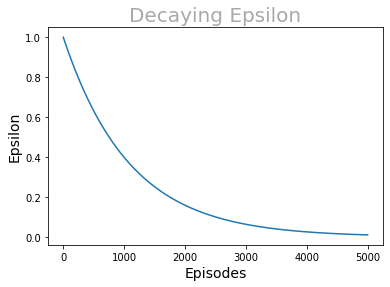

In [78]:
#DDQN
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(double_epsilon)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Epsilon", color = "black", fontsize = 14)
plt.title('Decaying Epsilon', color = "darkgrey", fontsize = 20)
plt.show()

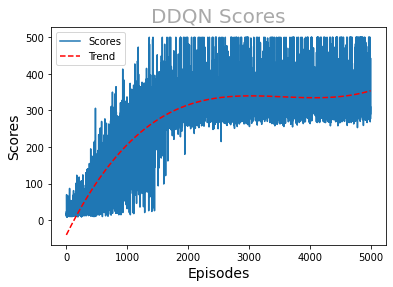

In [80]:
# the plot for rewards
x = np.arange(num_episodes) + 1
y = np.array(double_total_reward)
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(double_total_reward)
ax.plot(x, p(x), 'r--')
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Scores", color = "black", fontsize = 14)
plt.title('DDQN Scores', color = "darkgrey", fontsize = 20)
plt.legend(['Scores', 'Trend'])
plt.show()

In [129]:
import pandas as pd

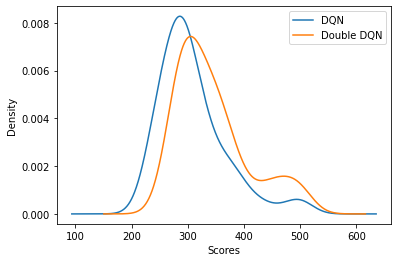

In [130]:
fig, ax = plt.subplots(1, 1)
_ = pd.Series(total_reward[-100:], name = "Score (DQN)").plot(kind = "kde", ax = ax, label = "DQN")
_ = pd.Series(double_total_reward[-100:], name = "Score (Double DQN)").plot(kind = "kde", ax = ax, label = "Double DQN")
_ = ax.set_xlabel("Scores")
_ = ax.legend()

In [147]:
# Q-network for overwriting the successful model previously saved
double_q_network_success = DoubleNeuralNetwork(env).to(device)
double_q_network_success.load_state_dict(torch.load('ddqn_for_cp-v1.pth'))

<All keys matched successfully>

In [148]:
double_eval_epi_reward = []
for i in range(5):
  double_eval_epi_reward.append(record_mp4(double_q_network_success, env, 0, f'cp_v1_ddqn-{i+1}'))

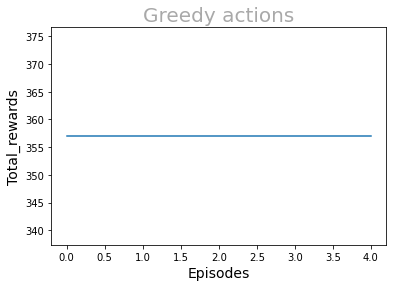

In [149]:
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(eval_epi_reward)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total_rewards", color = "black", fontsize = 14)
plt.title('Greedy actions', color = "darkgrey", fontsize = 20)
plt.show()